In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
batch_size = 32
image_size = 256

In [11]:
dataset = tf.keras.utils.image_dataset_from_directory("Batata",batch_size = batch_size, image_size=(image_size,image_size),shuffle=True)

Found 2152 files belonging to 3 classes.


In [12]:
print(tf.__version__)

2.16.1


In [13]:
# Folder names will be class names

In [14]:
dataset_name = dataset.class_names
dataset_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
# 68 because images are in the form of batches where each batch is 32    

In [16]:
len(dataset)

68

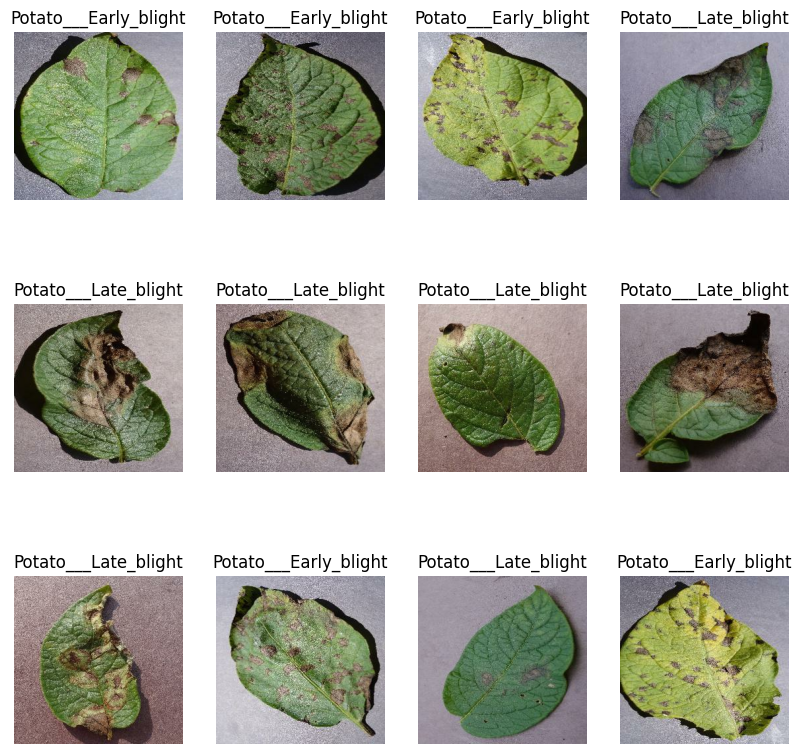

In [17]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        # subplot -> rows X columns -> 3,4 -> 3*4 -> 12 itesm in total
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset_name[label_batch[i]])
        plt.axis("off")

 ### 80% used for training data
### 20% mese => 10% used for validation and rest 10 used for testing data

### Get the len of training data

In [18]:
train_size = 0.8
train_size*len(dataset)

54.400000000000006

In [19]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [20]:
test_and_validation_dataset = dataset.skip(54)
len(test_and_validation_dataset)

14

In [21]:

len(dataset)*0.1

6.800000000000001

In [22]:
validation_ds = test_and_validation_dataset.take(6)
len(validation_ds)

6

In [23]:
test_ds = test_and_validation_dataset.skip(6)
len(test_ds)

8

In [24]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds


In [25]:
train_ds, test_ds, val_ds = get_dataset_partition(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(test_ds)

8

In [28]:
len(val_ds)

6

### Optimization

In [29]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Preprocessing (Scaling-converting the numbers from 0-255 to 0-1 | Resizing-changing the size of images, which might be more than image_size(variable) to fixed size)

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1.0/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2)
])

In [32]:
# convo2d -> convolutional model

n_classes = 3
channels = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # relu is taken bc it is fast
    layers.Convolution2D(32,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=(batch_size, image_size,image_size,channels))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 516128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │    33,032,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,033,347 (126.01 MB)

 Trainable params: 33,033,347 (126.01 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
# history = model.fit(train_dataset,batch_size=batch_size,validation_data=validation_ds,verbose=1,epochs=50)

### CHeck score of the model

In [36]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4949 - loss: 1.0266


In [37]:
scores

[1.0197229385375977, 0.515625]

In [38]:
# convo2d -> convolutional model

n_classes = 3
channels = 3

new_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # relu is taken bc it is fast
    layers.Conv2D(32,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),

    # repeat isliye kiya, to improve the accuracy 
    layers.Conv2D(64,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),

layers.Conv2D(64,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),

    # added new layer
    layers.Conv2D(64,(3,3),activation='relu', input_shape=(batch_size, image_size,image_size,channels) ),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

new_model.build(input_shape=(batch_size, image_size,image_size,channels))

In [39]:
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
new_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [41]:
# history = new_model.fit(train_dataset,batch_size=batch_size,validation_data=validation_ds,verbose=1,epochs=50)

In [42]:
scores = new_model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.1094 - loss: 1.1044


In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



NameError: name 'history' is not defined

In [ ]:
EPOCHS = 50
# The graph will show how much epoch is least required to get the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    # print image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print('first_image')
    plt.imshow(first_image)
    print('actual label - ',dataset_name[first_label])
    batch_prediction =  new_model.predict(images_batch)
    # print("all batches",batch_prediction)
    print('predicted label - ',dataset_name[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
        
    # incomplete hai
        prediction = model.predict(images_batch)

        predicted_class = dataset_name[np.argmax.prediction[0]]
        confidence = round(100*np.argmax(prediction[0]),2)
        return confidence,predicted_class

### Load and upload model

In [ ]:
# import os

# model_version = 1

# new_model.save(f"models/{model_version}.keras")

In [45]:
load_model = tf.keras.models.load_model('models/1/1.keras')
scores = load_model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9775 - loss: 0.0945


first_image
actual label -  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
predicted label -  Potato___Early_blight


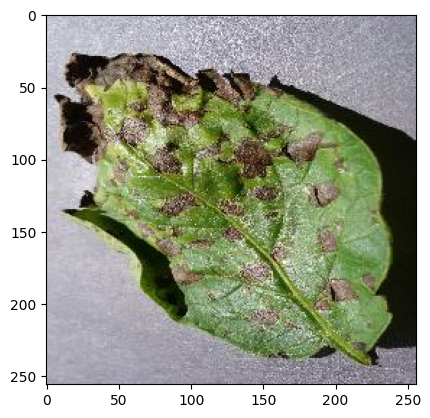

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    # print image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print('first_image')
    plt.imshow(first_image)
    print('actual label - ',dataset_name[first_label])
    batch_prediction =  load_model.predict(images_batch)
    # print("all batches",batch_prediction)
    print('predicted label - ',dataset_name[np.argmax(batch_prediction[0])])

### Auto increment model

In [ ]:
# import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
# model.save(f"../models/{model_version}")